### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="http://github.com/Nak007/anomaly"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Mount with google drive.
from google.colab import drive
drive.mount('/content/dirve')

# Import other libraries required.
# All *.py will be stored under the following 
# location i.e. '/content/anomaly'.
!git clone 'http://github.com/Nak007/anomaly.git'

In [25]:
# Import libraries.
import pandas as pd, numpy as np, sys
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt

# sys.path.append('/content/anomaly')
pd.options.display.float_format = '{:,.3f}'.format

In [26]:
from cluster_visualization import *
from Factor_Analysis import *
from Univariate import *
from varclus import *
from anomaly_detection import *

## Examples

In [4]:
from sklearn.datasets import load_breast_cancer as data
X, y = data(return_X_y=True)
X = pd.DataFrame(X, columns=[s.replace(' ','_') for s in data().feature_names])

### <font color="green" size=5> Variable Clustering </font>

[**`VariableClustering`**](https://github.com/Nak007/varclus) performs variable clustering with a hierarchical structure, and it is often used as a dimension reduction algorithm.

In [5]:
vc = VariableClustering(maxclus=20, maxeigval2=0.8).fit(X)

In [6]:
vc.info

,N_Vars,Eigval1,Eigval2,VarProp,min_RSO,max_RSN,max_RSr
Cluster,,,,,,,
1,8,7.282,0.502,0.910,0.716,0.725,1.035
2,5,4.132,0.543,0.826,0.651,0.601,0.571
3,5,3.630,0.763,0.726,0.479,0.534,0.776
4,2,1.912,0.088,0.956,0.956,0.118,0.050
5,3,1.815,0.603,0.605,0.599,0.207,0.485
6,3,2.908,0.066,0.969,0.957,0.590,0.106
7,2,1.805,0.195,0.903,0.903,0.355,0.151
8,2,1.700,0.300,0.850,0.850,0.328,0.223


In [7]:
vc.r2.head(10)

RS_Own  RS_NC  RS_Ratio
Cluster Variable                                     
1       worst_perimeter        0.979  0.556     0.046
        worst_radius           0.970  0.539     0.065
        mean_perimeter         0.968  0.520     0.067
        mean_radius            0.954  0.500     0.093
        mean_area              0.947  0.585     0.128
        worst_area             0.936  0.603     0.161
        mean_concave_points    0.812  0.618     0.493
        worst_concave_points   0.716  0.725     1.035
2       worst_compactness      0.908  0.348     0.141
        worst_concavity        0.893  0.412     0.181

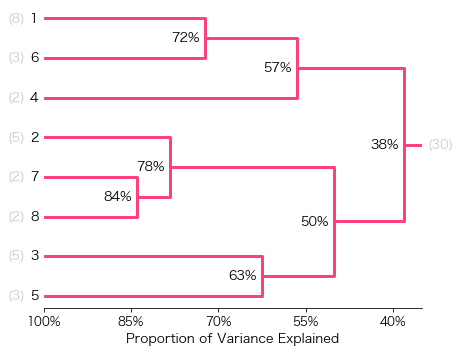

In [8]:
ax = vc.plot()

We can use **`cluster_matrix`** to visualize results from **`VariableClustering`** through a matrix of scatter plots.

In [9]:
cluster = 2
index = vc.clus_corr.index.get_level_values(0)==cluster
X0 = X[vc.clus_corr.loc[index].index.get_level_values(1)]

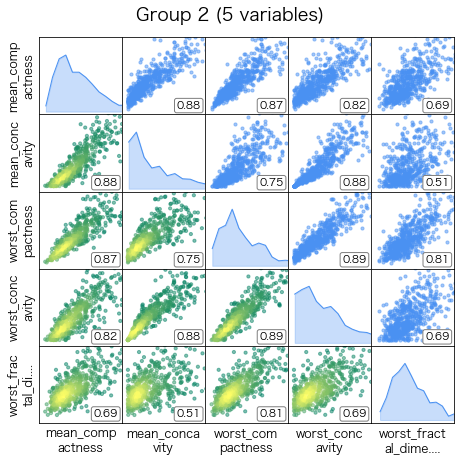

In [10]:
axes = cluster_matrix(X0, off_diagonal="both", scatter_kwds={"cmap":"summer"}, colors=["#4a91f2"])
plt.gcf().suptitle('Group {} ({:,d} variables)'.format(cluster, X0.shape[1]), fontsize=18)
plt.tight_layout()

Let's select variable, with the lowest **RS_Ratio** from each **Cluster**.

In [11]:
X = X[vc.r2.reset_index().groupby('Cluster').first()["Variable"].values].copy()

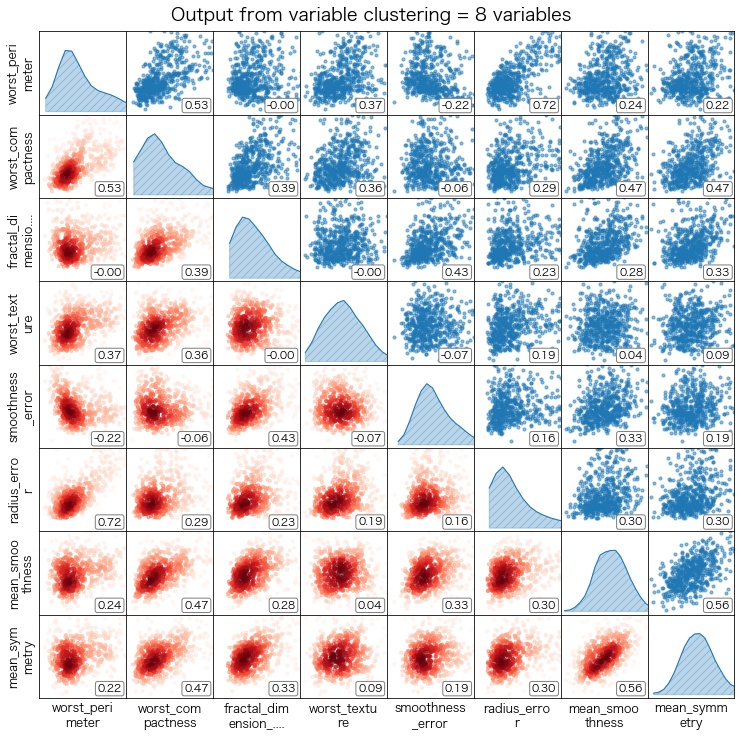

In [12]:
axes = cluster_matrix(X, off_diagonal="both", scatter_kwds=dict(cmap="Reds"),
                      hist_kwds=dict(sigma=1, fill_kwds=dict(hatch="///")), 
                      show_corr=True, label_kwds={"factor":0.95})
plt.gcf().suptitle('Output from variable clustering = {:,d} variables'
                   .format(X.shape[1]), fontsize=18)
plt.tight_layout()

### <font color="green" size=5> Standardization </font>

Standardize X by using [**`StandardScaler`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [13]:
Scaler = StandardScaler(with_mean=True, with_std=True).fit(X)
X_std  = pd.DataFrame(Scaler.transform(X), columns=X.columns)

In [14]:
def n_anomalies(y_pred):
    str_format = "# of anomalies: {:,d} ({:.0%})".format
    n_out = sum(y_pred)
    p_out = n_out / len(y_pred)
    print(str_format(n_out, p_out))

### <font size=5 color="green">Anomaly detection</font>

In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM, SVC
from sklearn.base import clone

### Isolation Forest
- For this example, [**`scikit-learn-isolationforest`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) from `sklearn.ensemble` is selected.
- Prediction array is comprised of **0** for **normal**, **1** for `anomaly`.

---
The [**`IsolationForest`**](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest) isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. 
Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of such random trees, is a measure of normality. The anomaly score $s$ of an instance $x$ is defined as: 

> $s(x,n) = 2^{-\frac{E(h(x)}{c(n)}}$
        
- Path Length $h(x)$ of a point $x$ is measured by the number of edges $x$ traverses an iTree from the root node.
- $c(n)$ is the average path length of iTree or the average of $h(x)$ given $n$, which can be expressed as:

> $c(n)$ = $2H(n − 1) − \frac{2(n − 1)}{n}$
- $H(i)$ is the harmonic number and it can be estimated by $H(i) ≈\log(i) + 0.5772156649$ (Euler’s constant).
- $H_{n}=1+{\frac{1}{2}}+{\frac {1}{3}}+\cdots +{\frac {1}{n}}=\sum _{k=1}^{n}{\frac {1}{k}}$
- $n$ is the number of samples.

In [16]:
IF = IsolationForest(**{"n_estimators"  : 200, 
                        "max_samples"   : 50, 
                        "max_features"  : 4, 
                        "random_state"  : 0, 
                        "contamination" : 'auto'}).fit(X_std)
y_pred_if = np.where(IF.predict(X_std)==-1,1,0)
n_anomalies(y_pred_if)

# of anomalies: 137 (24%)


It is noteworthy that anomaly score from **scikit-learn-isolationforest** [[**`1`**](https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09b/sklearn/ensemble/_iforest.py#L26),[**`2`**](https://stats.stackexchange.com/questions/335274/scikit-learn-isolationforest-anomaly-score)] does not follow the same calculation as stated in original paper as follows:

- $E(h(x))$ is expressed as follows:
> $E(h(x)) = \frac{1}{T}\sum_{i=1}^{T} \left(\sum_{j=1}^{{N}_{i}} (1|e_{j}\in e_{i,x}) + c(n(i,x))\right)$ 
    - $T$ is the number of estimators, 
    - $N_{i}$ is the number of nodes in tree $i$, 
    - $e_{i,x}$ is the nodes in $i$ that $x$ passes,
    - $c(n)$ = $2H(n − 1) − \frac{2(n − 1)}{n}$, and
    - $n(i,x)$ is the number of samples in $i$ at external node, where $x$ stops.
    
- average path length = $c($self.max_samples_$)$.
- max_depth = $int(\lceil\log_{2}(max($ self.max_samples $, 2))\rceil)$.
- use [**`sklearn.ensemble.ExtraTreeRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeRegressor.html) as a base estimator.
- y = np.random.uniform(size=X.shape[0])

Let's see where **`IsolationForest`** defines cutoff for anomaly.

 $s(x,n)_{sklearn}$ or `score_samples` = $\boxed{-s(x,n)_{original}}$

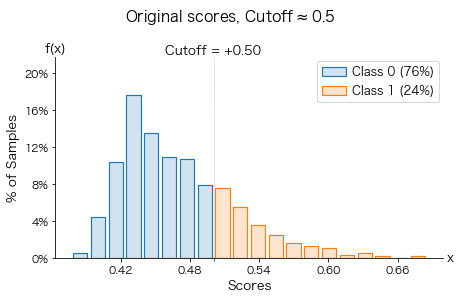

In [17]:
original_scores = -IF.score_samples(X_std)
ax = PlotScore_base(y_pred_if, original_scores)
plt.gcf().suptitle(r'Original scores, Cutoff$\approx$0.5', fontsize=15)
plt.tight_layout()

$E(h(x))$ is the average of $h(x)$ from a collection of isolation trees. The relationship between $E(h(x))$ and $s$ can be summarized as follow:
- If instances return $s$ very close to 1, then they are definitely anomalies, $\boxed{E(h(x)) \Longrightarrow 0, s \Longrightarrow 1}$.
- If instances have $s$ much smaller than 0.5, then they are quite safe to be regarded as normal instances, $\boxed{E(h(x)) \Longrightarrow n−1, s \Longrightarrow 0}$.
- If all the instances return $s$ ≈ 0.5, then the entire sample does not really have any distinct anomaly, $\boxed{E(h(x)) \Longrightarrow c(n), s \Longrightarrow 0.5}$.

`decision_function` = `score_samples` - `offset_`, where `offset` = -0.5 

Minimum score: -0.50
Maximum score: +0.50


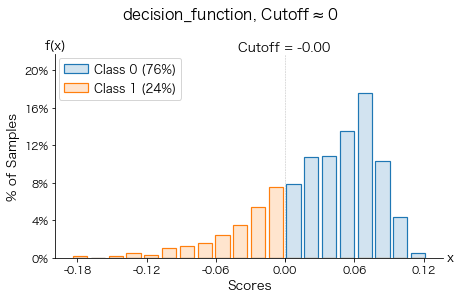

In [18]:
scores = IF.decision_function(X_std)
ax = PlotScore_base(y_pred_if, scores)
plt.gcf().suptitle(r'decision_function, Cutoff$\approx$0', fontsize=15)
plt.tight_layout()
print("Minimum score: {:+.2f}".format(-1-IF.offset_))
print("Maximum score: {:+.2f}".format(-IF.offset_))

From the above transformation (`decision_function`), the score can be interpreted as follows

- $E(h(x)) \Longrightarrow 0, score \Longrightarrow -0.5$.
- $E(h(x)) \Longrightarrow n−1, score \Longrightarrow 0.5$.
- $E(h(x)) \Longrightarrow c(n), s \Longrightarrow 0$.


If `decision_function` is less than 0 for any given `x`, such `x` is categorized as anomaly. This also depends on `offset_`.

Let's see how cuttoff works when `offset_` is changed.

# of anomalies: 39 (7%)
Minimum score: -0.45
Maximum score: +0.55


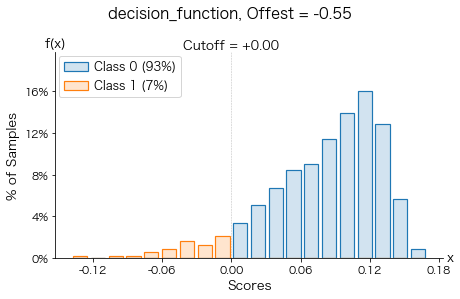

In [19]:
new_IF = clone(IF).fit(X_std)
new_IF.offset_ = -0.55
scores = new_IF.decision_function(X_std)
y_true = np.where(new_IF.predict(X_std)==-1,1,0)
ax = PlotScore_base(y_true, scores)
plt.gcf().suptitle('decision_function, Offest = {:.2f}'
                   .format(new_IF.offset_), fontsize=15)
plt.tight_layout()
n_anomalies(y_true)
print("Minimum score: {:+.2f}".format(-1-new_IF.offset_))
print("Maximum score: {:+.2f}".format(-new_IF.offset_))

### Local Outlier Factor

The [**`LocalOutlierFactor`**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) (LOF) algorithm computes a score (called local outlier factor) reflecting the degree of abnormality of the observations. It measures the local density deviation of a given data point with respect to its neighbors. The idea is to detect the samples that have a substantially lower density than their neighbors.

- Averge Reachability distance of $x$
> $ARD(x)$ = $\frac{1}{k}\sum_{i=1}^{k}max(d_{i,k},d_{i,x})$
    - $d_{i,k}$ is the $k^{th}$ nearest distance to $i$, 
    - $d_{i,x}$ is the distance between $i$ and $x$,
    - $k$ is the number of neighbours.
- Local Reachability distance of $x$
> $LRD(x)$ = $\frac{1}{ARD(x)}$
- Local Outlier Factor of $x$ 
> $LOF(x)$ = $\frac{\frac{1}{k}\sum_{i=1}^{k}LRD(i)}{LRD(x)}$

In [20]:
LOF = LocalOutlierFactor(n_neighbors=100, contamination='auto')
y_pred_lof = np.where(LOF.fit_predict(X_std)==-1,1,0)
n_anomalies(y_pred_lof)

# of anomalies: 32 (6%)


Let's see where **`LocalOutlierFactor`** defines cutoff for anomaly.

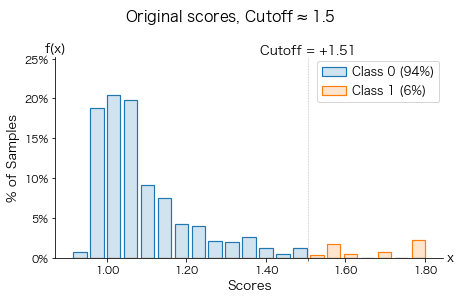

In [21]:
scores = np.clip(-LOF.negative_outlier_factor_, 0, 1.8)
ax = PlotScore_base(y_pred_lof, scores, bins=20)
plt.gcf().suptitle(r'Original scores, Cutoff$\approx$1.5', fontsize=15)
plt.tight_layout()

### One-Class SVM

[**`OneClassSVM`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) SVM proposed by Scholkopf et al. (2001) for estimating the support of a high-dimensional distribution (an unsupervised outlier detection). Given training vectors $x_{i} \in R^{n}, i = 1, \ldots,l$ without any class information, the primal problem of one-class SVM is

> Objective: min $\frac{1}{2}\bf{w}^{T}\bf{w} - \rho + \frac{1}{\nu l}\sum_{i=1}^{l}\xi_{i}$

> Subject to: $\bf{w}^{T}\phi(x_{i})\geq\rho-\xi_{i}, \xi_{i}\geq0, i = 1,\ldots,l$

The dual problem is

> Objective: min $\frac{1}{2}\alpha^{T}Q\alpha$

> Subject to: $0\leq\alpha_{i}\leq\frac{1}{\nu l}, i = 1,\ldots,l$, $\bf{e}^{T}\bf{\alpha} = 1$

where $\bf{e} = [1,\ldots,1]^{T}$ is the vector of all ones, and $Q_{i,j}= K(x_{i},x_{j}) = \phi(x_{i})^{T}\phi(x_{j}).$ The decision function is

> $f(x) = sgn \left( \sum_{i=1}^{l} \alpha_{i}K(x_{i},x) - \rho \right)$

The `decision_function` in `sklearn` is 

> $c(x) = \sum_{i \in SV} \alpha_{i}K(x_{i},x) + b$ or $\sum_{i \in SV} \alpha_{i}K(x_{i},x) - \rho$. 

These parameters can be accessed through the attributes `dual_coef_` which holds  holds the product $\alpha_{i}$, `support_vectors_` which holds the support vectors, `intercept_` which holds the independent term $b$, and  `offest_` which holds the independent term $\rho$.

In [27]:
from sklearn.datasets import make_blobs
samples = make_blobs(n_samples   = 100, 
                     n_features  = 2, 
                     centers     = 2, 
                     cluster_std = [1, 1.5], 
                     center_box  = (-10, 10), 
                     random_state= 100)[0]

OCSVM = OneClassSVM(nu=0.12, kernel="rbf", gamma=0.1).fit(samples)

In [28]:
def plot_svc_decision_function(model, ax, plot_vectors=True):
    """Plot the decision function for a 2D SVC"""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_vectors:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none',
                   edgecolor="k")
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.patch.set_alpha(0)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', labelsize=11)

% Anomalies: 12%
Ratio (n_outliers/n_supports): 80%


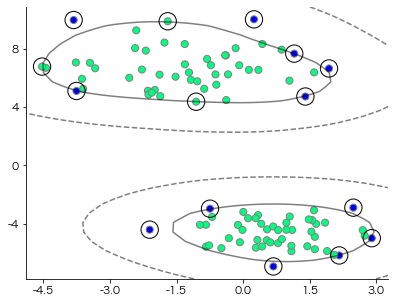

In [29]:
fig, ax = plt.subplots(figsize=(6.5,5))
ax.scatter(samples[:,0], samples[:,1], c=OCSVM.predict(samples), s=50, cmap="winter", ec="grey")
plot_svc_decision_function(OCSVM, ax) 
desc_SVs = OCSVM.decision_function(OCSVM.support_vectors_)
print("% Anomalies: {:.0%}".format(np.mean(OCSVM.predict(samples)<0)))
print("Ratio (n_outliers/n_supports): {:.0%}".format(np.mean(desc_SVs<0)))

In [30]:
ocsvm = OneClassSVM(kernel="rbf", nu=0.1, gamma=0.1).fit(X_std)
scores = ocsvm.decision_function(X_std)
y_pred_svm = np.where(ocsvm.predict(X_std)==1,0,1)
n_anomalies(y_pred_svm)

# of anomalies: 59 (10%)


Let's see where **`OneClassSVM`** defines cutoff for anomaly.

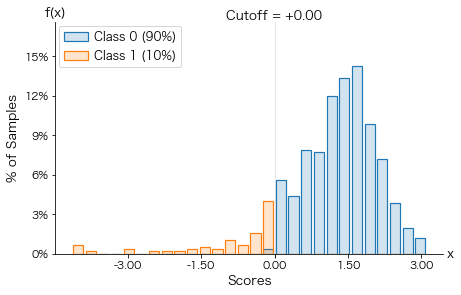

In [31]:
ax = PlotScore_base(y_pred_svm, scores)

In [32]:
y_pred = y_pred_svm + y_pred_lof + y_pred_if
y_pred = np.where(y_pred>1, 1, 0)

**<font size=5 color='green'> Compare2samp </font>**

In [**`Compare2samp`**](https://github.com/Nak007/univariate/blob/main/Univariate_colab.ipynb), it uses Chi-Square ($\chi^{2}$), Kolmogorov–Smirnov (KS), and Population-Stability-Index (PSI) tests to measure the difference between two distributions. Such difference can be viewed as one of the factors that differentiate between two groups of instances.

**Note**: This function runs on scikit-learn 0.24.2

In [33]:
compare = Compare2samp(frac=0.02, max_category=1000).fit(X_std.loc[y_pred==0], 
                                                         X_std.loc[y_pred==1])

Summary of results

In [34]:
compare.info.sort_values(by=["chi2_chisq","ks_stat"], 
                         ascending=[False, False])

,chi2_chisq,chi2_df,chi2_pvalue,chi2_bins,ks_stat,ks_pvalue,psi,dtype
variable,,,,,,,,
fractal_dimension_error,999.000,6,0.000,7,0.492,0.000,1.921,float32
worst_compactness,999.000,7,0.000,8,0.269,0.001,0.864,float32
smoothness_error,943.682,6,0.000,7,0.279,0.001,0.780,float32
worst_perimeter,634.285,7,0.000,8,0.209,0.025,0.816,float32
mean_symmetry,447.329,6,0.000,7,0.341,0.000,1.008,float32
radius_error,395.195,5,0.000,6,0.313,0.000,0.672,float32
mean_smoothness,390.242,6,0.000,7,0.269,0.001,0.639,float32
worst_texture,349.342,6,0.000,7,0.163,0.138,0.494,float32


To visualize, use `plotting`.

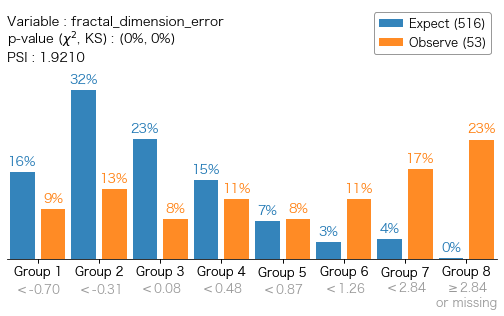

In [34]:
var = np.random.choice(list(X_std))
ax = compare.plotting(var, max_display=1, xticklabel_format="{:,.2f}".format)

**<font size=5 color='green'> PrincipalComponents </font>**

Visaulize principal components in pair and see how features influence the spread or cluster of data, see [**`PrincipalComponents`**](https://github.com/Nak007/cluster/blob/main/clustering_colab.ipynb).

In [35]:
PCF = PrincipalComponents(mineigval=1.0).fit(X_std)

In [36]:
PCF.communalities

Extraction                              
                               PC1   PC2   PC3   PC4 Communality
worst_perimeter              0.449 0.382 0.074 0.013       0.918
worst_compactness            0.610 0.025 0.181 0.004       0.819
fractal_dimension_error      0.256 0.295 0.000 0.135       0.686
worst_texture                0.139 0.234 0.042 0.422       0.836
smoothness_error             0.059 0.555 0.133 0.090       0.836
radius_error                 0.478 0.048 0.408 0.004       0.939
mean_smoothness              0.484 0.112 0.021 0.103       0.721
mean_symmetry                0.483 0.067 0.080 0.086       0.717
Total                        2.959 1.718 0.940 0.856       6.473

Select `n` ramdomized pairs of factors to display.

In [37]:
r = range(PCF.n_factors)
combi = np.r_[list(combinations(r, 2))]
n_plots  = min(3, len(r))
pc_pairs = combi[np.random.choice(r, n_plots, replace=False)].tolist()

Keyword arguments for `plot` function.

In [38]:
arrow_colors=matplotlib_cmap(name="coolwarm", n=X_std.shape[1])
kwds = dict(arrow_colors=arrow_colors, max_display=5, show_corr=False, 
            whis=3, y=y_pred, scatter_colors=["#b2bec3","#d63031"])

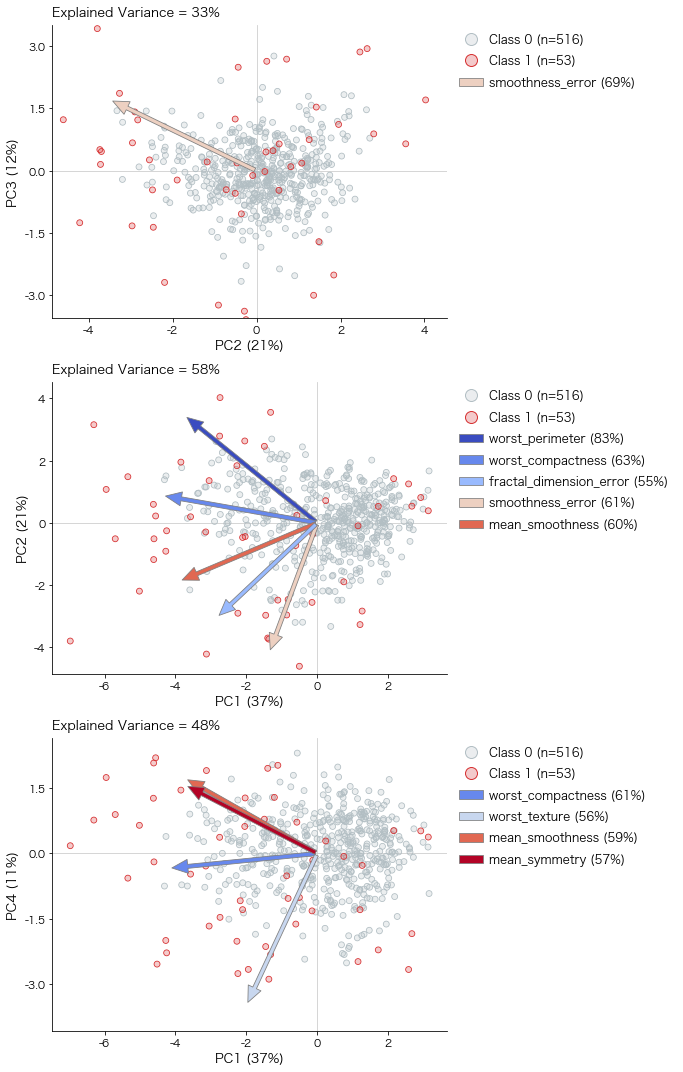

In [39]:
axes = plt.subplots(n_plots, 1, figsize=(n_plots*3.2, 15))[1]
for ax,pc_pair in zip(axes, pc_pairs):
    kwds.update(dict(pc_pair=pc_pair, ax=ax))
    ax = PCF.plot(**kwds)
plt.tight_layout()

**<font size=5 color='green'> cluster_matrix </font>**

Visaulize variables in pairwise manner and see how features influence the spread or cluster of data, see [**`cluster_matrix`**](https://github.com/Nak007/cluster/blob/main/clustering_colab.ipynb).

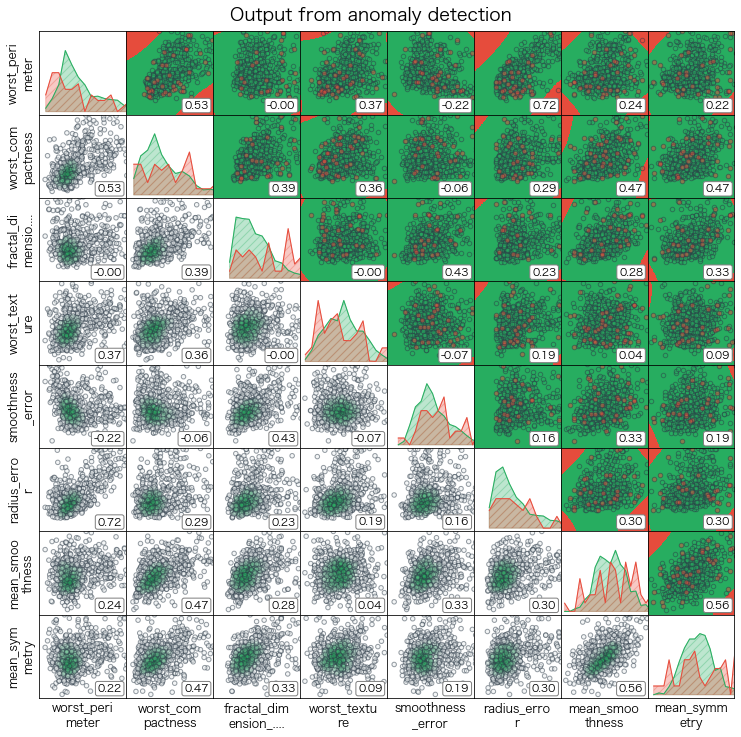

In [44]:
axes = cluster_matrix(X_std, off_diagonal="both", 
                      scatter_kwds=dict(cmap=create_cmap(["#27ae60"] + ["#ecf0f1"]*2), 
                                        decision=True, 
                                        estimator=SVC(kernel="poly", degree=4, C=10, random_state=0),
                                        scatter_kwds=dict(s=20, edgecolor="#2C3A47")),
                      hist_kwds=dict(fill_kwds=dict(hatch="///")), 
                      show_corr=True, y=y_pred, colors=["#27ae60","#e74c3c"])
plt.gcf().suptitle('Output from anomaly detection', fontsize=18)
plt.tight_layout()

**<font size=5 color='green'> cluster_radar </font>**

Alternatively, we can use features or other numerical variables to observe the characteristics of each class.

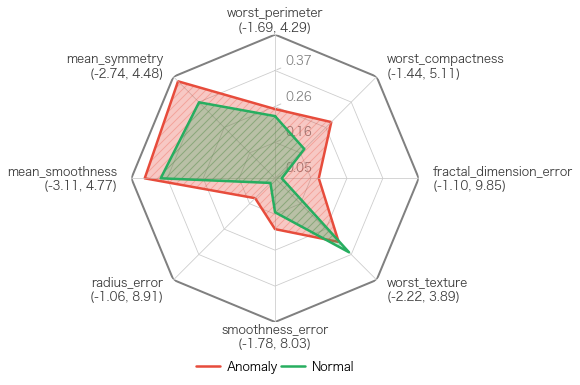

In [42]:
ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))[1]
ax = cluster_radar(X_std, y_pred, ax=ax,
                   colors=["#e74c3c", "#27ae60"], 
                   labels=["Anomaly", "Normal"], fill_kwds={"hatch":"///"}, 
                   plot_order=[1,0])